In [1]:
import sys
sys.path.append("../src")

import numpy as np
import matplotlib.pyplot as plt

from pgg_env import PGGParallelEnv
from agents import make_pgg_agents
from loop_pgg import run_simulation

from analysis_PGG import (
    coop_timecourse_mean_sd,
    mean_coop,
    cc_mcc,
    alpha_fit_polyfit
)
SEED = 123
rng = np.random.default_rng(SEED)

# fix parameters
EPSILON = 0.2
P_INIT = 0.5
GRID_SIZE = 10
X_tresh = 0.5  # Treshold for cooperation


In [ ]:
def make_env(tmax):
    return PGGParallelEnv(ep_leng=tmax)

def make_agents_list(n_agents, A, beta, p_init=P_INIT, tresh=0.5):
    return make_pgg_agents(n_agents, A=A, beta=beta, p_init=p_init, coop_threshold=tresh)

def run_trials(A, beta, tmax, n_trials, seed=SEED, p_init=P_INIT, treshold = 0.5):
    env = make_env(tmax=tmax)
    agents = make_agents_list(env.n_agents, A=A, beta=beta, p_init=p_init, tresh=treshold)
    actions_all, rewards_all, p_all, _ = run_simulation(
        env=env,
        agents=agents,
        n_episodes=n_trials,
        ep_lenght_max=tmax,
        seed=seed,
        render=False
    )

    return env, actions_all, rewards_all, p_all


### First Test

In [ ]:
tmax_3 = 25
n_trials_3 = 25000 # augmente pour 1000

fig3_settings = [
    ("A", 0.3),
    ("B", 0.4),
    ("C", 0.5),
]

fig3_curves = {}

for label, X_tresh in fig3_settings:
    env, actions_all, _, _ = run_trials(
        A=0.9, beta=0.5, tmax=tmax_3, n_trials=n_trials_3, treshold=X_tresh
    )

    curves = cc_mcc(actions_all, t_start=1, t_end=tmax_3, tresh=X_tresh)
    fig3_curves[label] = (curves, X_tresh)

print("Done Fig 3 sims.")

Done Fig 3 sims.


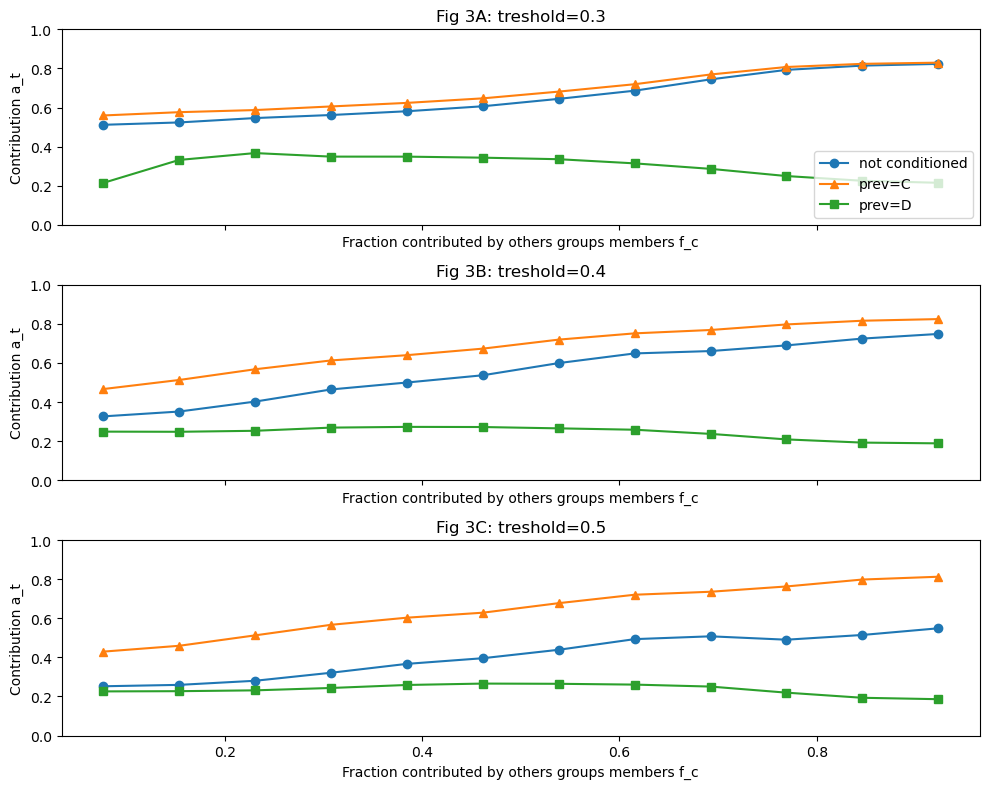

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (label, X) in zip(axes, fig3_settings):
    curves, X_tresh = fig3_curves[label]
    f = curves["f_vals"]

    ax.plot(f, curves["pC"], marker="o", label="not conditioned")
    ax.plot(f, curves["pC_C"], marker="^", label="prev=C")
    ax.plot(f, curves["pC_D"], marker="s", label="prev=D")

    ax.set_title(f"Fig 3{label}: treshold={X_tresh}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Fraction contributed by others groups members f_c")
    ax.set_ylabel("Contribution a_t")

axes[0].legend(loc="lower right")
plt.tight_layout()
plt.show()


In [6]:
tmax_4 = 25
n_trials_4 = 120

A_values_4 = np.linspace(-0.5, 3.5, 20)
beta_values_4 = np.linspace(0.05, 2.0, 20)

a1_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)
a2_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)

a1C_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)
a2C_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)

a1D_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)
a2D_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)

for iA, A in enumerate(A_values_4):
    for iB, beta in enumerate(beta_values_4):
        env, actions_all, _, _ = run_trials(A=A, beta=beta, tmax=tmax_4, n_trials=n_trials_4, treshold=0.4)

        a1, a2, _ = alpha_fit_polyfit(actions_all, condition=None,    t_start=1, t_end=tmax_4,tresh=0.4)
        a1C, a2C, _ = alpha_fit_polyfit(actions_all, condition="prevC", t_start=1, t_end=tmax_4, tresh=0.4)
        a1D, a2D, _ = alpha_fit_polyfit(actions_all, condition="prevD", t_start=1, t_end=tmax_4, tresh=0.4)

        a1_map[iA, iB], a2_map[iA, iB] = a1, a2
        a1C_map[iA, iB], a2C_map[iA, iB] = a1C, a2C
        a1D_map[iA, iB], a2D_map[iA, iB] = a1D, a2D

delta_a2 = a2C_map - a2D_map

print("Done Fig 4 sweep (polyfit).")


Done Fig 4 sweep (polyfit).


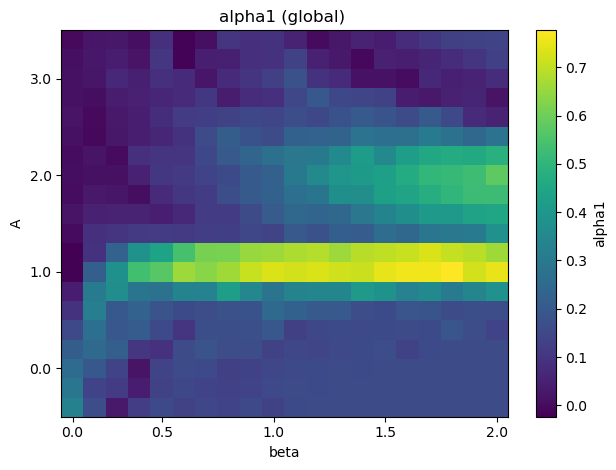

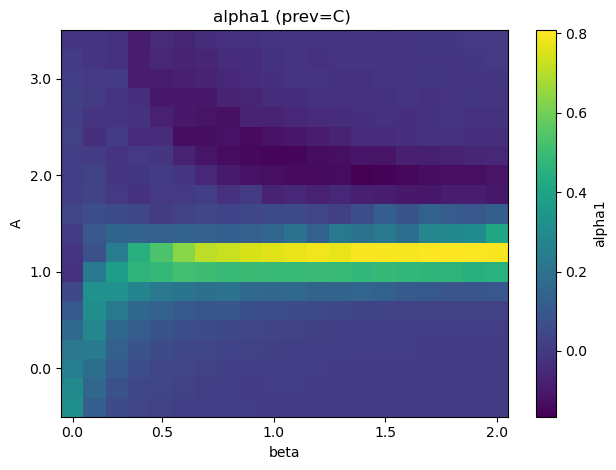

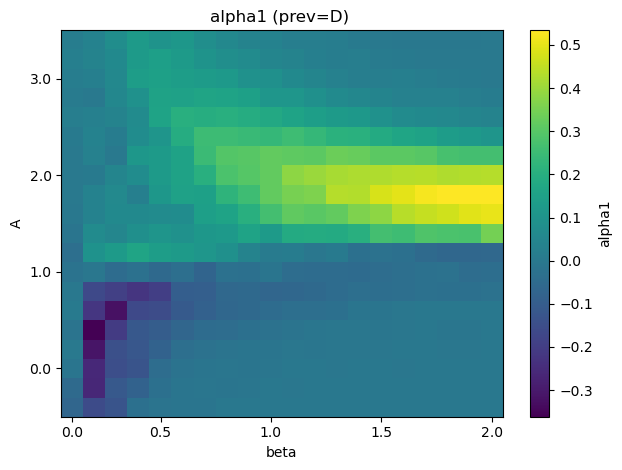

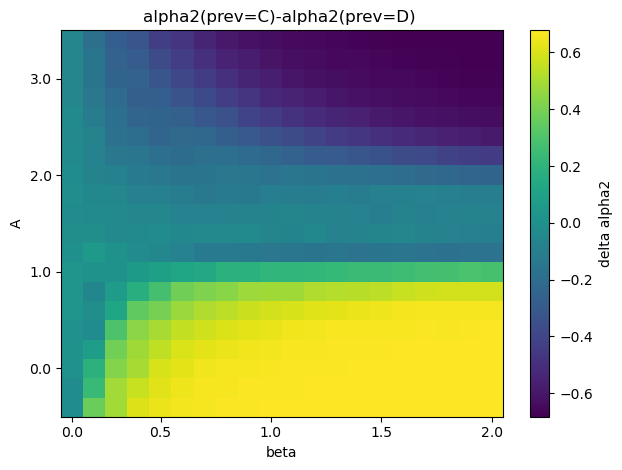

In [7]:
def show_heatmap(M, title, beta_values, A_values, cbar_label):
    plt.figure()
    im = plt.imshow(M, origin="lower", aspect="auto")
    cbar = plt.colorbar(im, label=cbar_label)

    beta_ticks = [0.0, 0.5, 1.0, 1.5, 2.0]
    A_ticks = [0.0, 1.0, 2.0,3.0]
    beta_idx = [int(np.argmin(np.abs(beta_values - v))) for v in beta_ticks]
    A_idx = [int(np.argmin(np.abs(A_values - v))) for v in A_ticks]
    plt.xticks(beta_idx, [str(v) for v in beta_ticks])
    plt.yticks(A_idx, [str(v) for v in A_ticks])

    plt.xlabel("beta")
    plt.ylabel("A")
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_heatmap(a1_map, "alpha1 (global) ", beta_values_4, A_values_4, "alpha1")
show_heatmap(a1C_map, "alpha1 (prev=C) ", beta_values_4, A_values_4, "alpha1")
show_heatmap(a1D_map, "alpha1 (prev=D) ", beta_values_4, A_values_4, "alpha1")
show_heatmap(delta_a2, "alpha2(prev=C)-alpha2(prev=D) ", beta_values_4, A_values_4, "delta alpha2")